<a href="https://colab.research.google.com/github/Azatotych/Removing_noise_from_photos/blob/main/%D0%9A%D0%BE%D0%B4_%D0%B4%D0%BB%D1%8F_%D0%93%D0%BE%D0%BB%D0%BE%D1%88%D1%83%D0%BC%D0%BE%D0%B2%D0%B0_%D0%B8%D0%B4%D0%B5%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import imutils
import cv2
import os
from imutils import paths
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.datasets import cifar10
import os

# Создаем папку, если ее нет
if not os.path.exists('/content/images'):
    os.makedirs('/content/images')

# Загружаем датасет
(x_train, _), (_, _) = cifar10.load_data()

# Выбираем первые 2000 изображений


170498071/170498071 [==============================] - 7s 0us/step


In [ ]:
img_r = 32
folder_path = "/content/images"
dataset = []
for image_name in x_train:
    image = Image.fromarray(image_name)
    image = image.resize((img_r, img_r))
    image2arr = np.array(image) / 255
    dataset.append(image2arr)

In [ ]:
x_train, x_test = train_test_split(dataset, test_size= 0.25, random_state = 42)

In [ ]:
noise =  np.random.normal(loc=0, scale=1, size=(img_r,img_r,1))
x_train_noise = np.clip((np.array(x_train)+noise*0.4),0,1)
x_test_noise = np.clip((np.array(x_test)+noise*0.4),0,1)


In [ ]:
x_test = np.array(x_test)
x_train_noise = np.array(x_train_noise)
x_test_noise = np.array(x_test_noise)
x_train = np.array(x_train)


In [ ]:
print(x_train.shape)
print(x_train_noise.shape)
print(x_test.shape)
print(x_test_noise.shape)

(37500, 32, 32, 3)
(37500, 32, 32, 3)
(12500, 32, 32, 3)
(12500, 32, 32, 3)


In [ ]:
input_layer = Input(shape=(img_r,img_r,3))
#encoder
encoded_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer2)
decoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
output_layer = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(decoded_layer2)


In [ ]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464 

In [ ]:
history = model.fit(x_train_noise, x_train, epochs=50, validation_data=(x_test_noise, x_test))

Epoch 1/50
1172/1172 [==============================] - 25s 11ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 2/50
1172/1172 [==============================] - 12s 11ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 3/50
1172/1172 [==============================] - 13s 11ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/50
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 5/50
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/50
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/50
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/50
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/50
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/50
1172/1172 [==============================] - 12s 10m

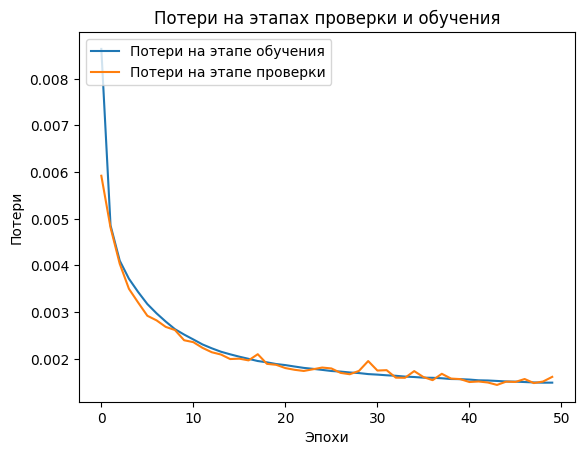

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Потери на этапах проверки и обучения')
plt.ylabel('Потери')
plt.xlabel('Эпохи')
plt.legend(['Потери на этапе обучения', 'Потери на этапе проверки'], loc='upper left')
plt.show()

In [ ]:
json_string = model.to_json()
model.save_weights('autoencoder.h5')
open('autoencoder_N_04_50.h5','w').write(json_string)

7002

Код для загрузки архитектуры и весов.


In [ ]:
from keras.models import model_from_json

# Загрузка архитектуры модели из файла JSON
json_file = open('learned_N_04_50.h5', 'r')
loaded_json_model = json_file.read()
json_file.close()

# Создание модели из архитектуры
model = model_from_json(loaded_json_model)

# Загрузка весов в модель
model.load_weights('learned.h5')

1/1 [==============================] - 0s 18ms/step


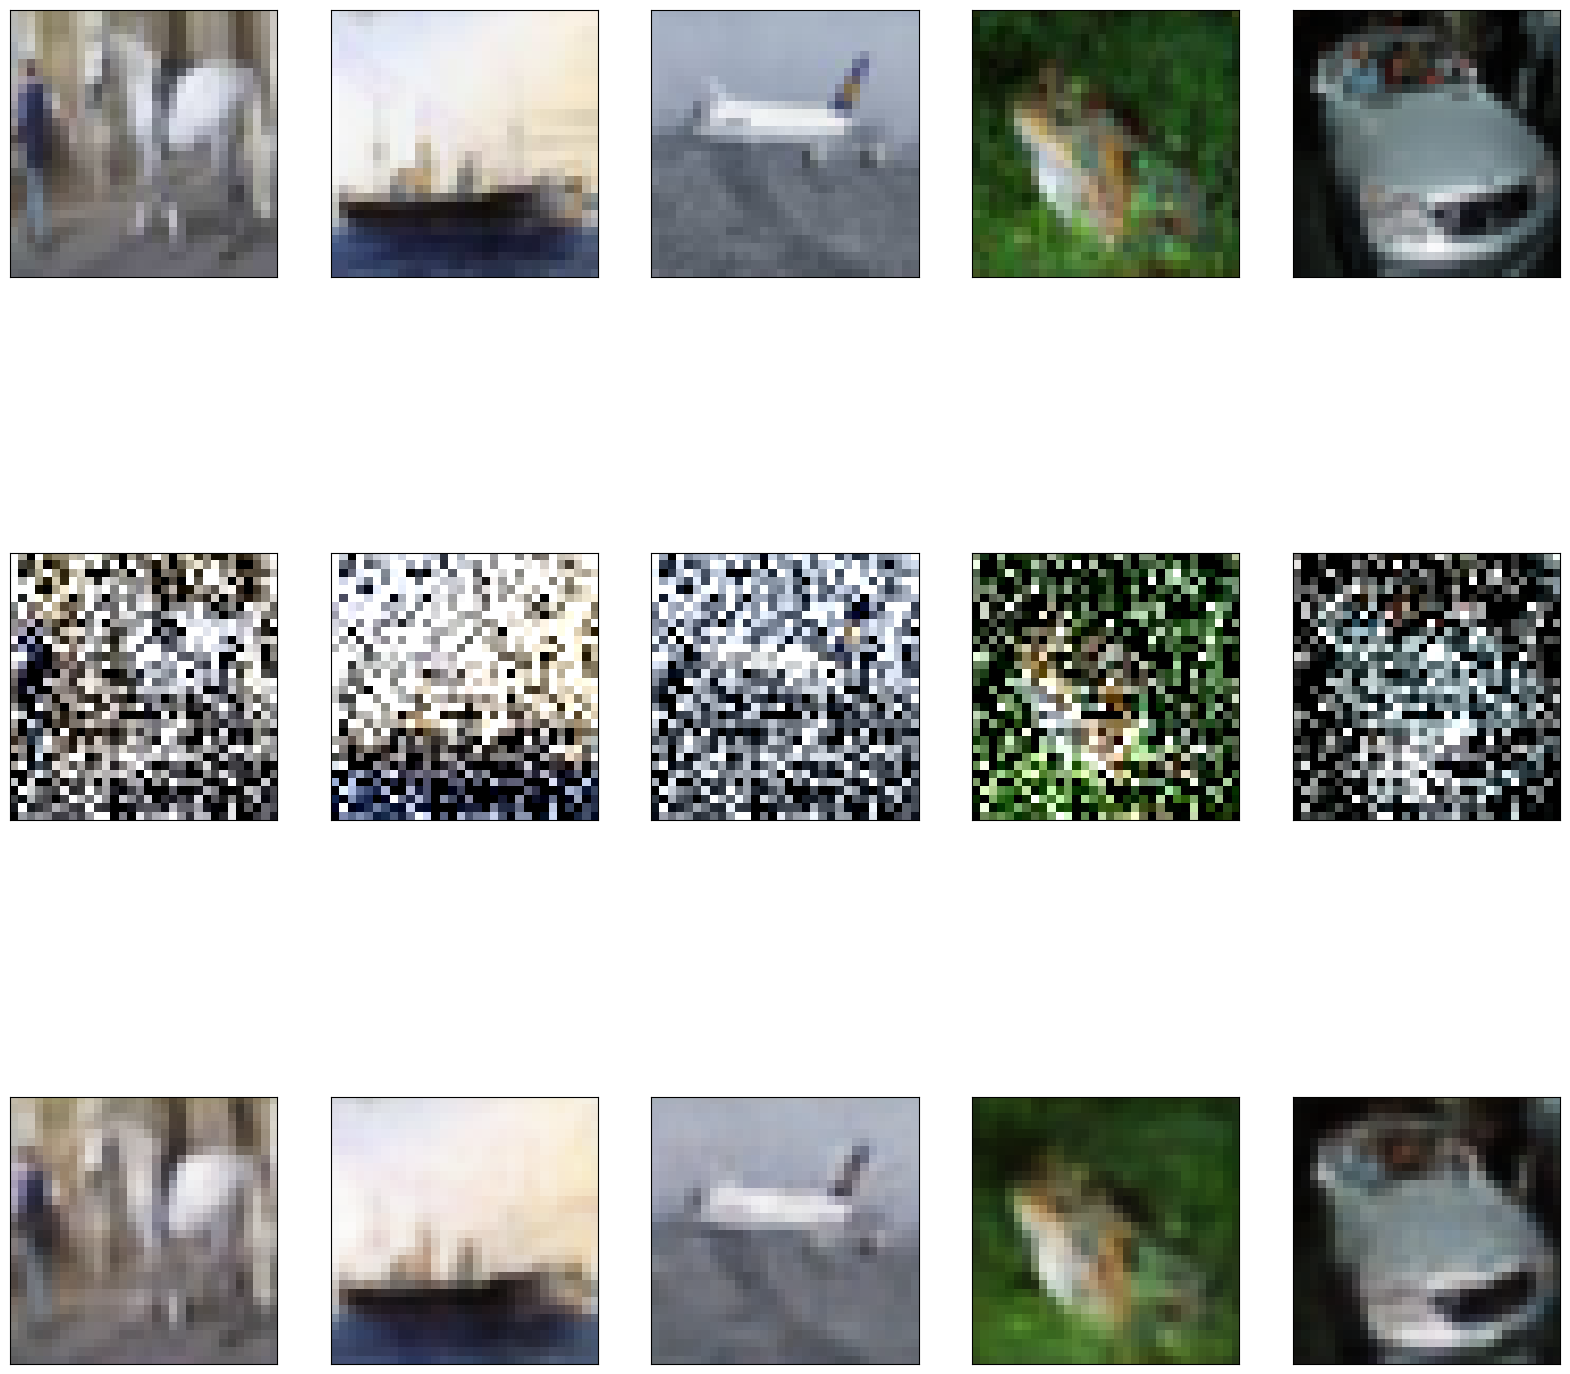

In [ ]:
n = 5
plt.figure(figsize=(20, 20))

for i in range(n):
    # оригинальные изображения
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # зашумленные изображения
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noise[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # восстановление изображений автоэнкодером
    restored_img = model.predict(np.expand_dims(x_test_noise[i], axis=0))[0]

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(restored_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [ ]:
from tensorflow.keras.datasets import mnist
img_r = 32

In [ ]:
(x_train, _), (_, _) = mnist.load_data()
test_i = x_train[:10]
test_i_rgb = np.stack((test_i, test_i, test_i), axis=-1)

In [ ]:
dataset = []
for image_name in test_i_rgb:
    image = Image.fromarray(image_name)
    image = image.resize((img_r, img_r))
    image2arr = np.array(image) / 255
    dataset.append(image2arr)

In [ ]:
noise =  np.random.normal(loc=0, scale=1, size=(img_r,img_r,1))
x_testi_noise = np.clip((np.array(dataset)+noise*0.4),0,1)


1/1 [==============================] - 0s 33ms/step


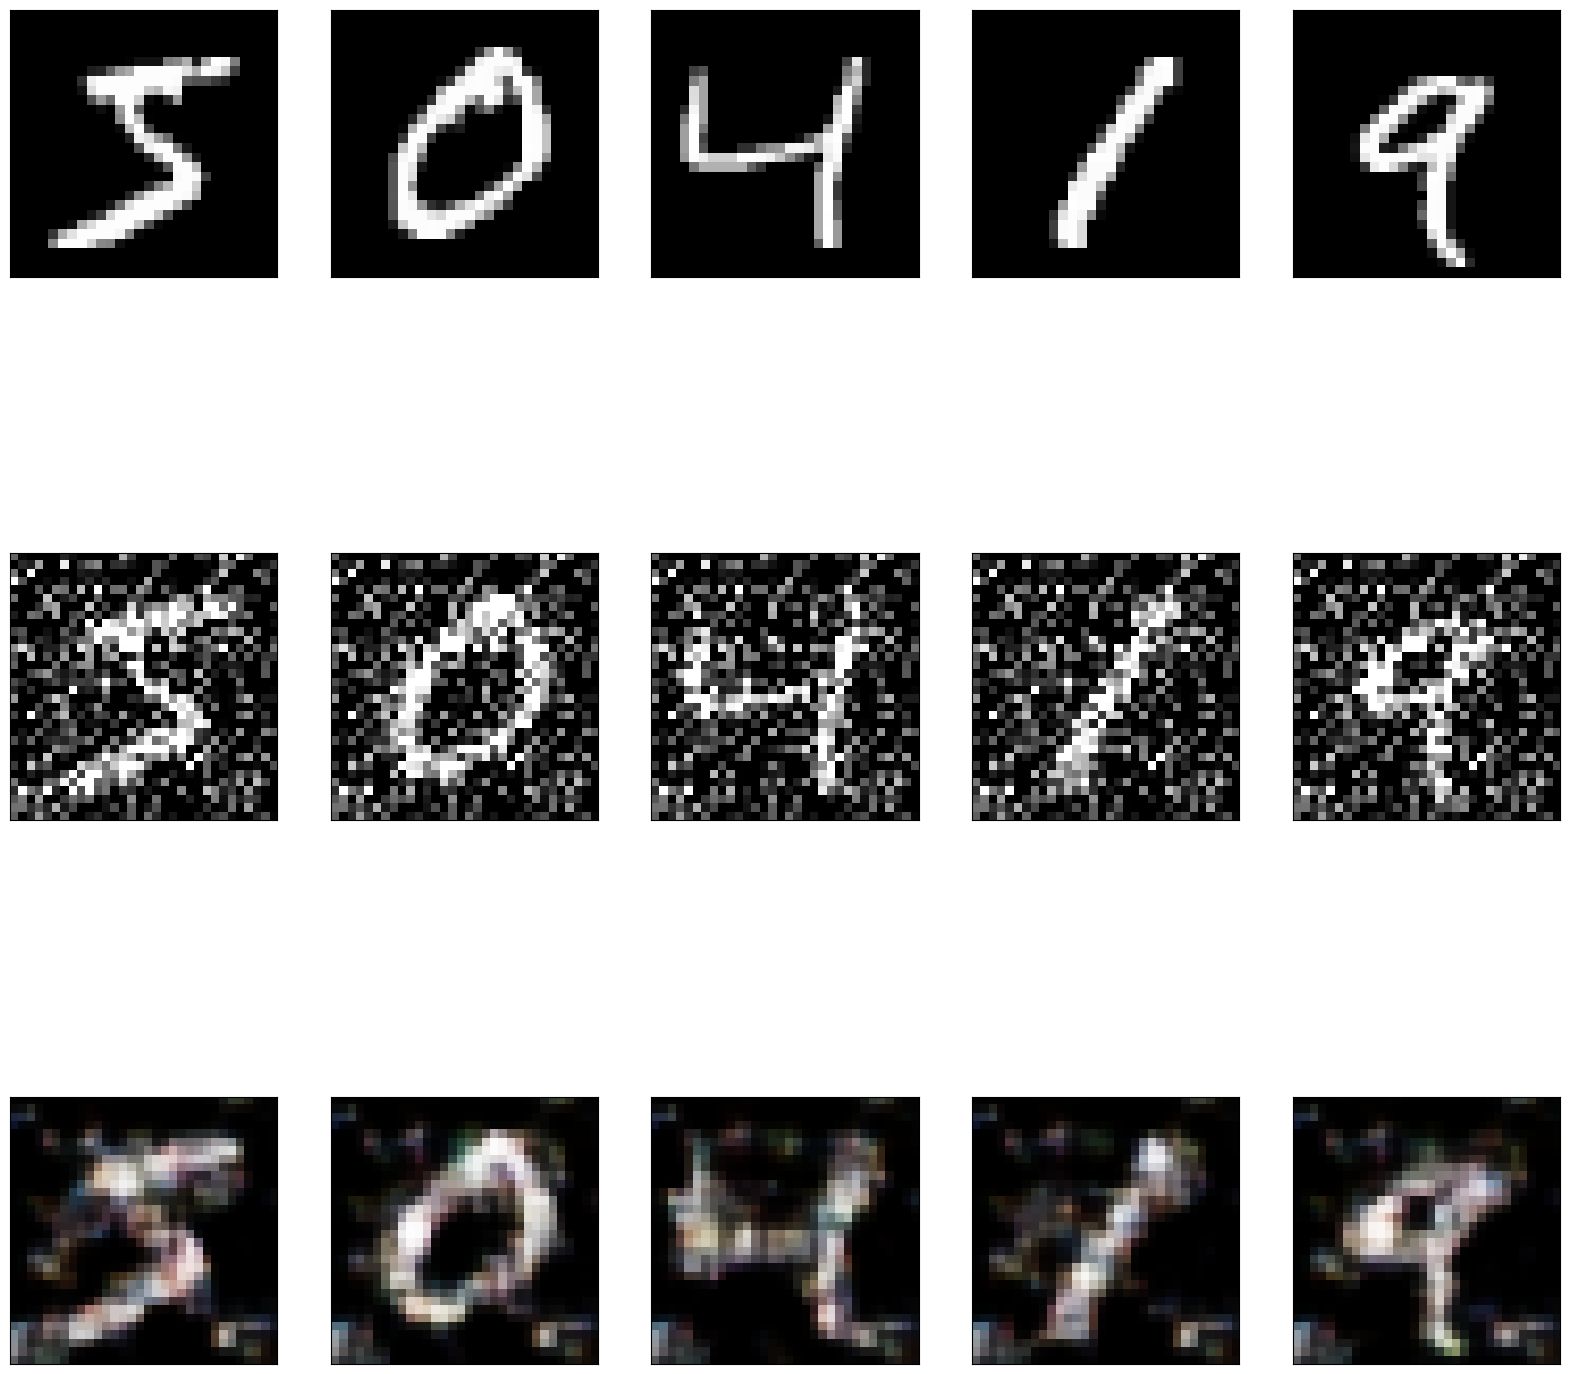

In [ ]:
n = 5
plt.figure(figsize=(20, 20))

for i in range(n):
    # оригинальные изображения
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_i[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # зашумленные изображения
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_testi_noise[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # восстановление изображений автоэнкодером
    restored_img = model.predict(np.expand_dims(x_testi_noise[i], axis=0))[0]

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(restored_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
